In [1]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
import morfeusz2
import pl_core_news_md

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('polish'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [2]:
DATAPATH = r'../../data/raw/train.tsv'
STOPWORDS = r'E:\coding\pythonnew\POLHATE-project\data\raw\polish_stopwords.txt'

In [3]:
df = pd.read_csv(DATAPATH, delimiter = '\t')
df.head()

,sentence,target
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

In [4]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

df['text_clean'] = df['sentence'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [5]:
# Tokenizing the tweet base texts.
df['tokenized'] = df['text_clean'].apply(word_tokenize)
df.head()

,sentence,target,text_clean,tokenized
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,Dla mnie faworytem do tytułu będzie Cracovia Z...,"[Dla, mnie, faworytem, do, tytułu, będzie, Cra..."
1,@anonymized_account @anonymized_account Brawo ...,0,anonymizedaccount anonymizedaccount Brawo ty D...,"[anonymizedaccount, anonymizedaccount, Brawo, ..."
2,"@anonymized_account @anonymized_account Super,...",0,anonymizedaccount anonymizedaccount Super pols...,"[anonymizedaccount, anonymizedaccount, Super, ..."
3,@anonymized_account @anonymized_account Musi. ...,0,anonymizedaccount anonymizedaccount Musi Innej...,"[anonymizedaccount, anonymizedaccount, Musi, I..."
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,Odrzut natychmiastowy kwaśna mina mam problem,"[Odrzut, natychmiastowy, kwaśna, mina, mam, pr..."


In [6]:
# Lower casing clean text.

df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

df.head()

,sentence,target,text_clean,tokenized,lower
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,Dla mnie faworytem do tytułu będzie Cracovia Z...,"[Dla, mnie, faworytem, do, tytułu, będzie, Cra...","[dla, mnie, faworytem, do, tytułu, będzie, cra..."
1,@anonymized_account @anonymized_account Brawo ...,0,anonymizedaccount anonymizedaccount Brawo ty D...,"[anonymizedaccount, anonymizedaccount, Brawo, ...","[anonymizedaccount, anonymizedaccount, brawo, ..."
2,"@anonymized_account @anonymized_account Super,...",0,anonymizedaccount anonymizedaccount Super pols...,"[anonymizedaccount, anonymizedaccount, Super, ...","[anonymizedaccount, anonymizedaccount, super, ..."
3,@anonymized_account @anonymized_account Musi. ...,0,anonymizedaccount anonymizedaccount Musi Innej...,"[anonymizedaccount, anonymizedaccount, Musi, I...","[anonymizedaccount, anonymizedaccount, musi, i..."
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,Odrzut natychmiastowy kwaśna mina mam problem,"[Odrzut, natychmiastowy, kwaśna, mina, mam, pr...","[odrzut, natychmiastowy, kwaśna, mina, mam, pr..."


In [7]:
# Removing stopwords.

df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop])

df.head()

,sentence,target,text_clean,tokenized,lower,stopwords_removed
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,Dla mnie faworytem do tytułu będzie Cracovia Z...,"[Dla, mnie, faworytem, do, tytułu, będzie, Cra...","[dla, mnie, faworytem, do, tytułu, będzie, cra...","[faworytem, tytułu, cracovia, zobaczymy, typ, ..."
1,@anonymized_account @anonymized_account Brawo ...,0,anonymizedaccount anonymizedaccount Brawo ty D...,"[anonymizedaccount, anonymizedaccount, Brawo, ...","[anonymizedaccount, anonymizedaccount, brawo, ...","[brawo, daria, kibic, dobre, złe]"
2,"@anonymized_account @anonymized_account Super,...",0,anonymizedaccount anonymizedaccount Super pols...,"[anonymizedaccount, anonymizedaccount, Super, ...","[anonymizedaccount, anonymizedaccount, super, ...","[super, polski, premier, składa, kwiaty, groba..."
3,@anonymized_account @anonymized_account Musi. ...,0,anonymizedaccount anonymizedaccount Musi Innej...,"[anonymizedaccount, anonymizedaccount, Musi, I...","[anonymizedaccount, anonymizedaccount, musi, i...","[innej, drogi, mamy]"
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,Odrzut natychmiastowy kwaśna mina mam problem,"[Odrzut, natychmiastowy, kwaśna, mina, mam, pr...","[odrzut, natychmiastowy, kwaśna, mina, mam, pr...","[odrzut, natychmiastowy, kwaśna, mina, problem]"


In [8]:
morf = morfeusz2.Morfeusz()
def lemmatize(wordlist: list) -> str:
    """Lemmatizes polish text from given tweet.
    Args:
        text (str): Text to preprocess.
    Returns:
        lemmatizedText (str): Lemmatized text.

    """
    wordList = " ".join([x for x in wordlist])
    lemmatizedWordList = []

    for word in wordlist:    
        _, _, interpretation = morf.analyse(word)[0]
        lemWord = interpretation[1]
        lemWordStripped = lemWord.split(':', 1)[0].lower()
        lemmatizedWordList.append(lemWordStripped)

    lemmatizedText = ' '.join(lemmatizedWordList)

    return lemmatizedText.split()



In [9]:
df['lemmatized'] = df['stopwords_removed'].apply(lemmatize)

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

,sentence,target,text_clean,tokenized,lower,stopwords_removed,lemmatized,lemma_str
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0,Dla mnie faworytem do tytułu będzie Cracovia Z...,"[Dla, mnie, faworytem, do, tytułu, będzie, Cra...","[dla, mnie, faworytem, do, tytułu, będzie, cra...","[faworytem, tytułu, cracovia, zobaczymy, typ, ...","[faworyt, tytuł, cracovia, zobaczyć, typ, spra...",faworyt tytuł cracovia zobaczyć typ sprawdzić
1,@anonymized_account @anonymized_account Brawo ...,0,anonymizedaccount anonymizedaccount Brawo ty D...,"[anonymizedaccount, anonymizedaccount, Brawo, ...","[anonymizedaccount, anonymizedaccount, brawo, ...","[brawo, daria, kibic, dobre, złe]","[brawo, daria, kibic, dobry, zły]",brawo daria kibic dobry zły
2,"@anonymized_account @anonymized_account Super,...",0,anonymizedaccount anonymizedaccount Super pols...,"[anonymizedaccount, anonymizedaccount, Super, ...","[anonymizedaccount, anonymizedaccount, super, ...","[super, polski, premier, składa, kwiaty, groba...","[super, polski, premier, składać, kwiat, grób,...",super polski premier składać kwiat grób kolabo...
3,@anonymized_account @anonymized_account Musi. ...,0,anonymizedaccount anonymizedaccount Musi Innej...,"[anonymizedaccount, anonymizedaccount, Musi, I...","[anonymizedaccount, anonymizedaccount, musi, i...","[innej, drogi, mamy]","[drogi, mama]",drogi mama
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0,Odrzut natychmiastowy kwaśna mina mam problem,"[Odrzut, natychmiastowy, kwaśna, mina, mam, pr...","[odrzut, natychmiastowy, kwaśna, mina, mam, pr...","[odrzut, natychmiastowy, kwaśna, mina, problem]","[odrzut, natychmiastowy, kwaśny, mina, problem]",odrzut natychmiastowy kwaśny mina problem


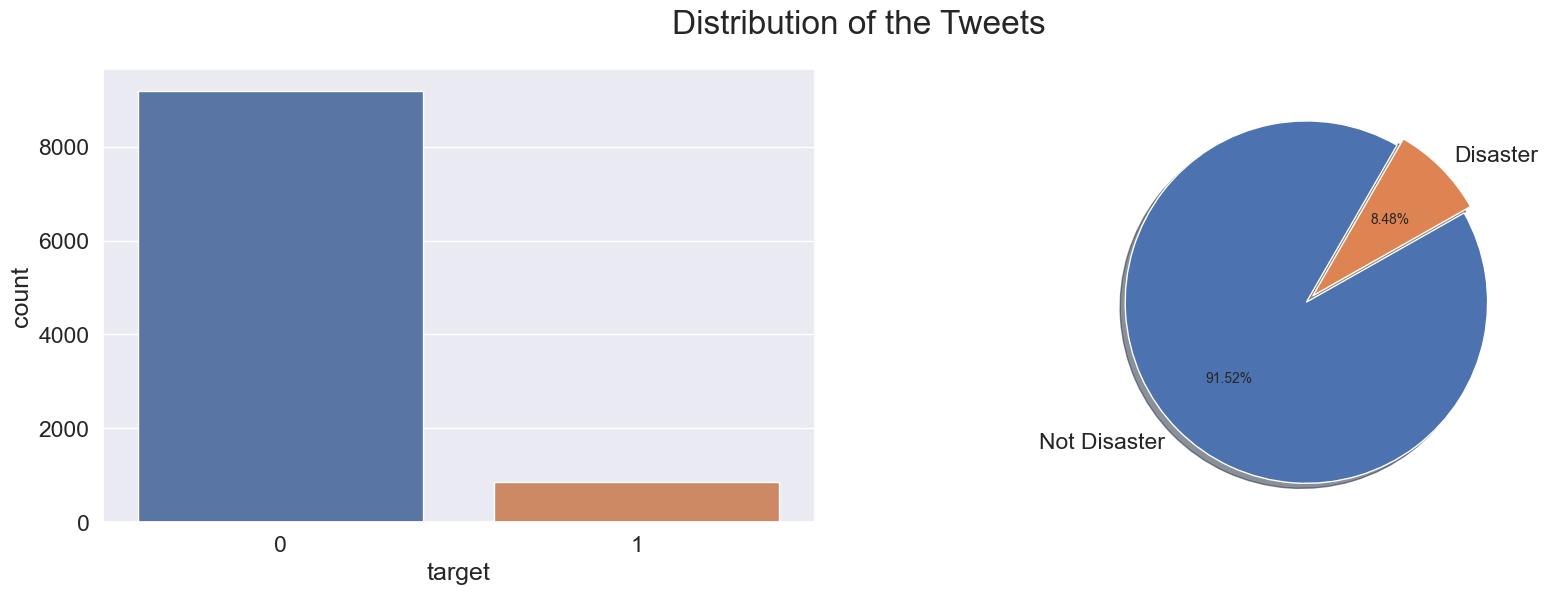

In [10]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [11]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

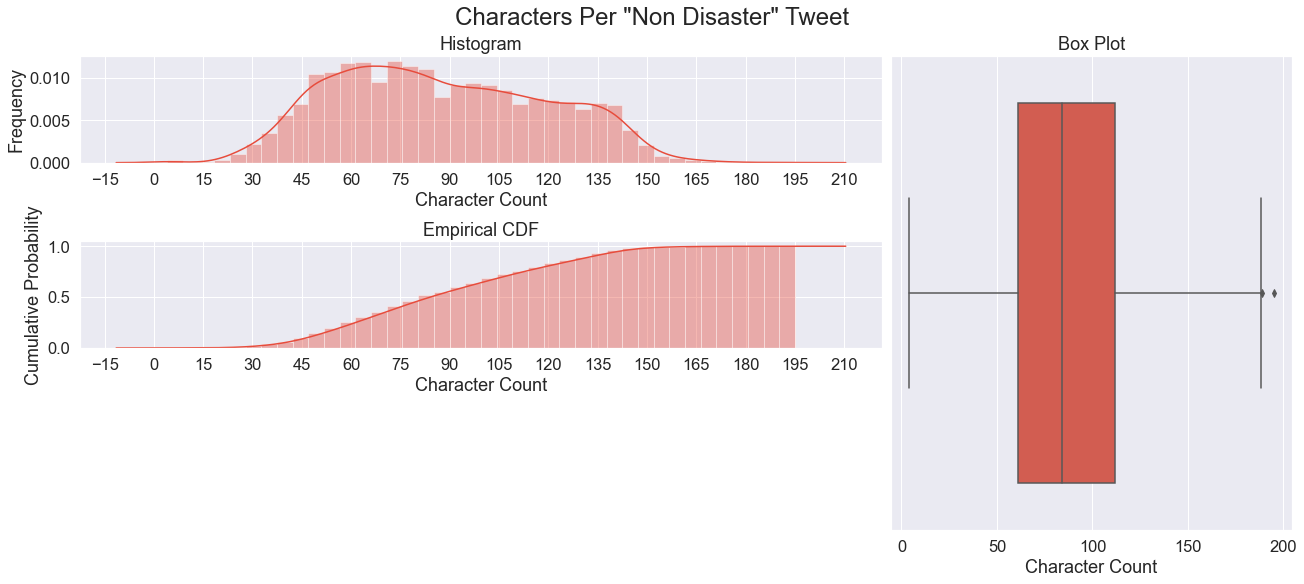

In [12]:
plot_dist3(df[df['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

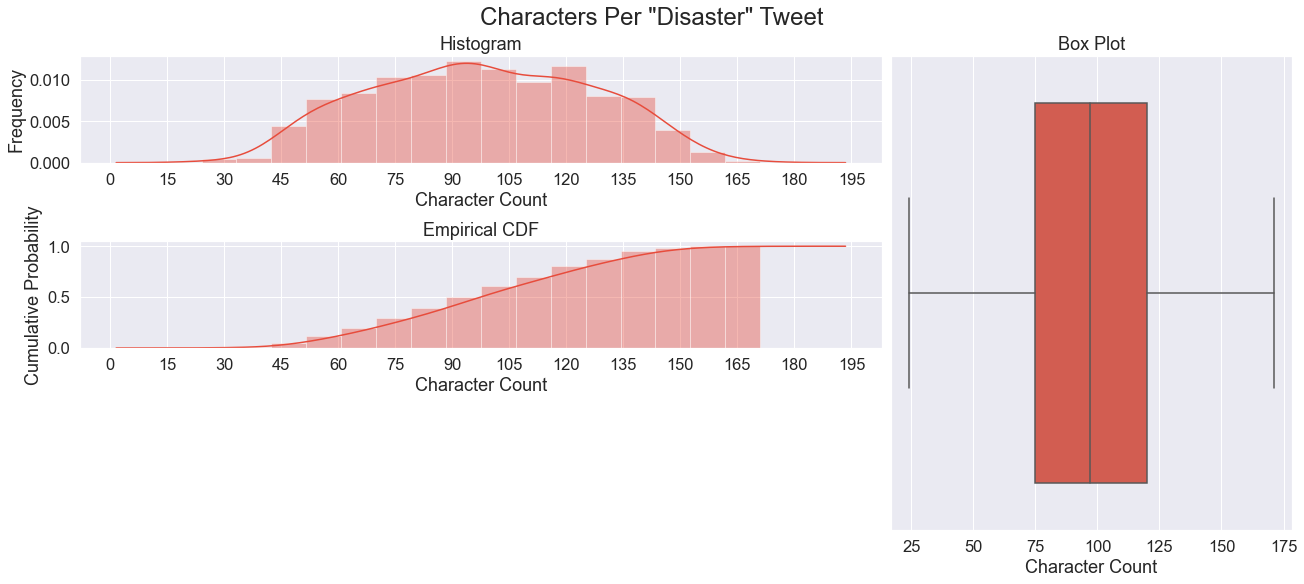

In [13]:
plot_dist3(df[df['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

In [14]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

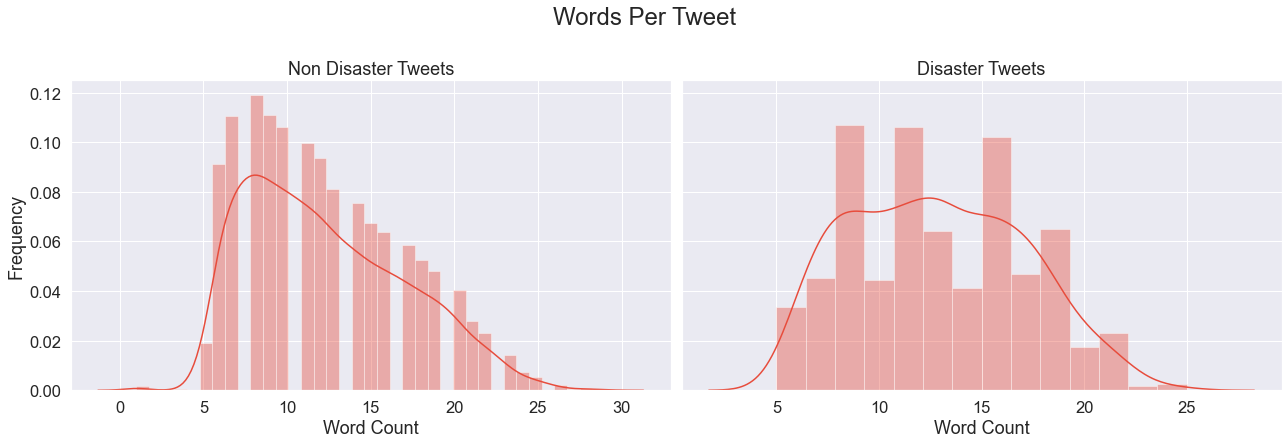

In [15]:
plot_word_number_histogram(df[df['target'] == 0]['sentence'],
                           df[df['target'] == 1]['sentence'])

In [16]:
def plot_word_len_histogram(textno, textye):
    
    """A function for comparing average word length"""
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

In [17]:
lis = [
    df[df['target'] == 0]['lemma_str'],
    df[df['target'] == 1]['lemma_str']
]

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


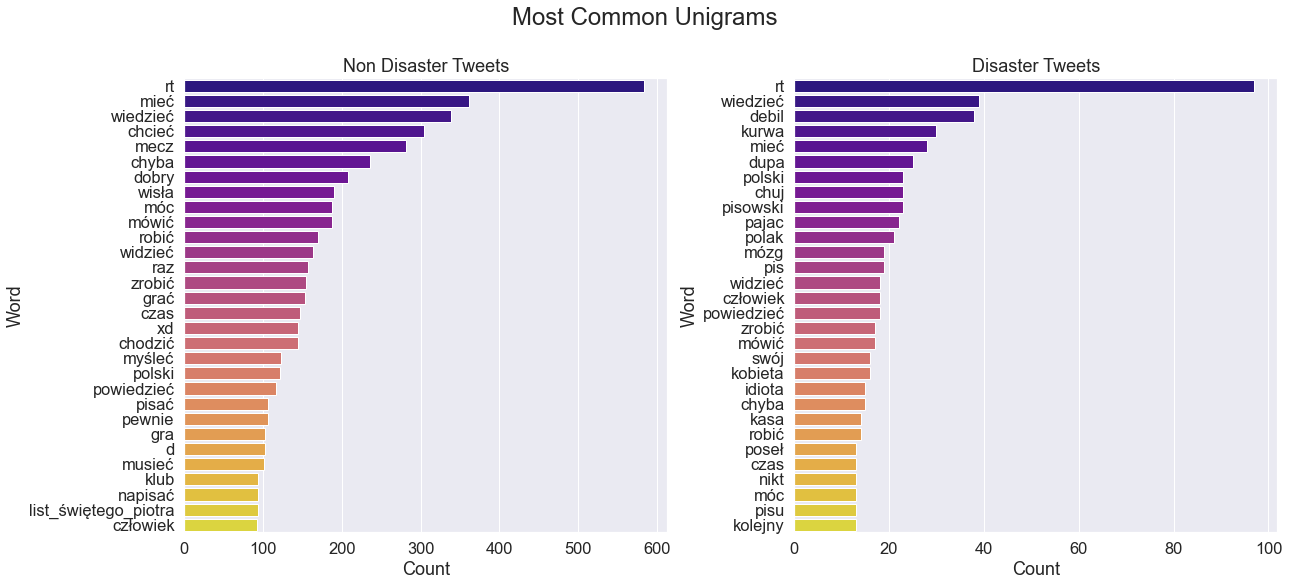

In [19]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [20]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

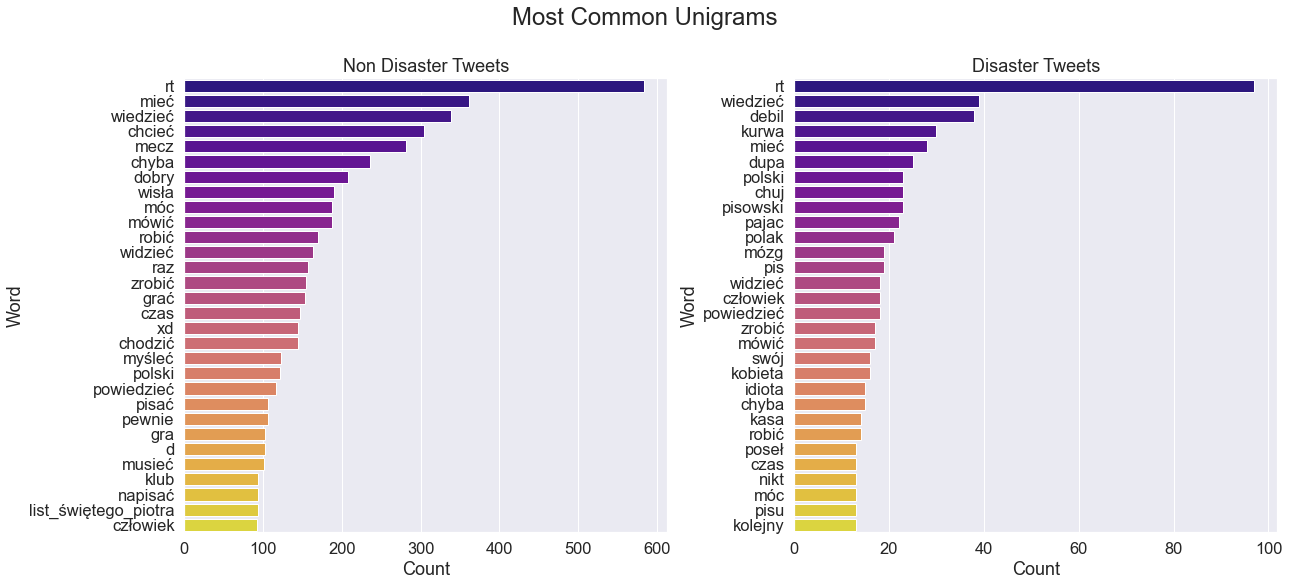

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

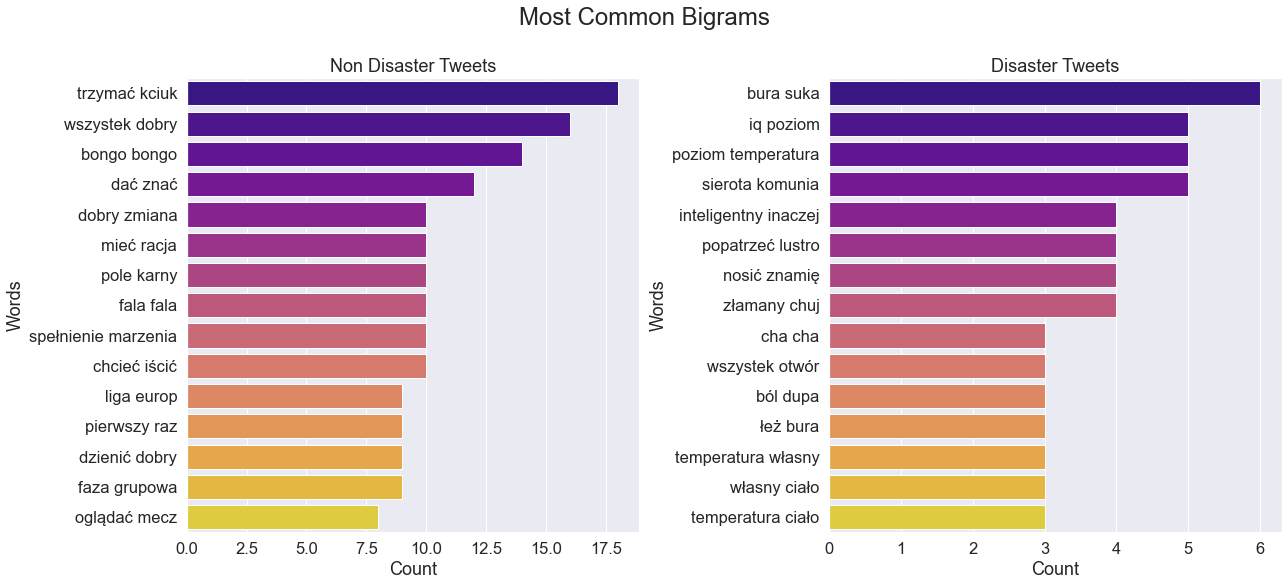

In [22]:
ngrams(2, 'Most Common Bigrams')

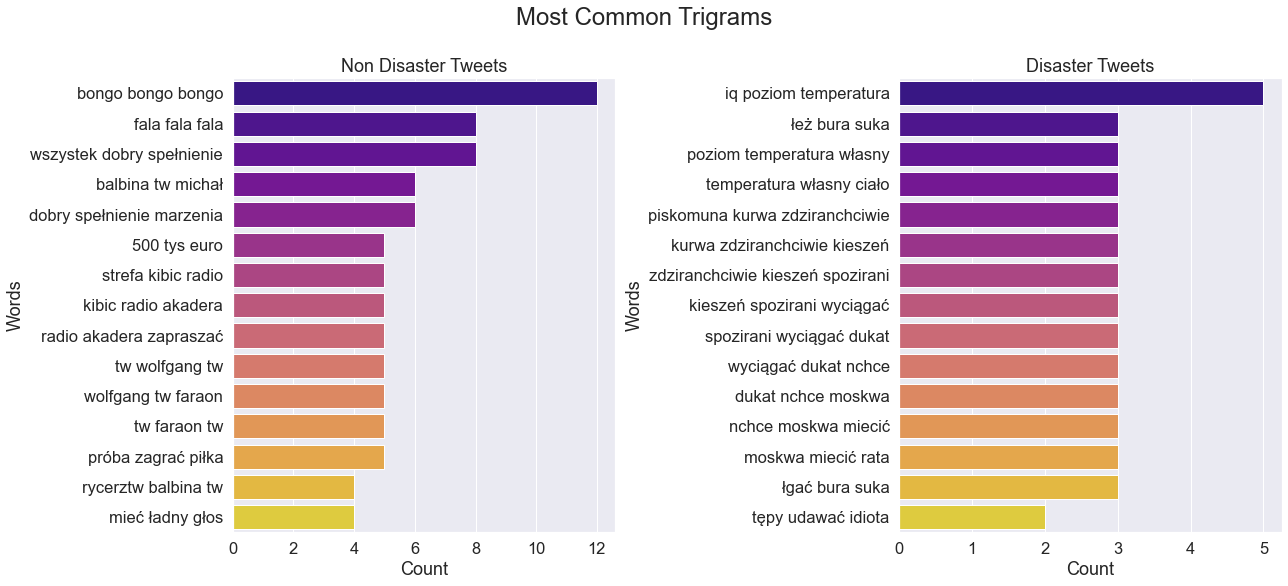

In [23]:
ngrams(3, 'Most Common Trigrams')

# Building the Bert Model
Finally it's time to start building our model. We gonna use BERT for this task with the help of library called Transformers which makes our work much more smoother...

In [24]:
# If there's a GPU available...

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1060 3GB


In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)
print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(5))

Number of training tweets: 7530

Number of training tweets: 2511



,sentence,target,text_clean,tokenized,lower,stopwords_removed,lemmatized,lemma_str,Character Count
817,@anonymized_account Dobry argument żeby zamkną...,0,anonymizedaccount Dobry argument żeby zamknąć ...,"[anonymizedaccount, Dobry, argument, żeby, zam...","[anonymizedaccount, dobry, argument, żeby, zam...","[dobry, argument, zamknąć, mordy, biedronka, p...","[dobry, argument, zamknąć, mord, biedronka, pł...",dobry argument zamknąć mord biedronka płacić w...,100
4688,"imagine, mieszkać w drewnianym domku i w lesie",0,imagine mieszkać w drewnianym domku i w lesie,"[imagine, mieszkać, w, drewnianym, domku, i, w...","[imagine, mieszkać, w, drewnianym, domku, i, w...","[imagine, mieszkać, drewnianym, domku, lesie]","[imagine, mieszkać, drewniany, domek, las]",imagine mieszkać drewniany domek las,45
1309,@anonymized_account A te slajdy to macie od Mo...,0,anonymizedaccount A te slajdy to macie od Mora...,"[anonymizedaccount, A, te, slajdy, to, macie, ...","[anonymizedaccount, a, te, slajdy, to, macie, ...","[slajdy, macie, morawieckiego]","[slajd, mieć, morawiecki]",slajd mieć morawiecki,55
6434,@anonymized_account @anonymized_account Kim je...,0,anonymizedaccount anonymizedaccount Kim jest j...,"[anonymizedaccount, anonymizedaccount, Kim, je...","[anonymizedaccount, anonymizedaccount, kim, je...","[kim, dealer, pasowałoby, trochę, dobrego, tow...","[dealer, pasować, trocha, dobre, towar]",dealer pasować trocha dobre towar,89
3084,@anonymized_account Ej zrób mi takie tez xd,0,anonymizedaccount Ej zrób mi takie tez xd,"[anonymizedaccount, Ej, zrób, mi, takie, tez, xd]","[anonymizedaccount, ej, zrób, mi, takie, tez, xd]","[ej, zrób, tez, xd]","[ej, zrobić, teza, xd]",ej zrobić teza xd,41


In [26]:
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.sentence.values

## Tokenization and Formatting the Inputs
For feeding our text to BERT we have to tokenize our text first and then these tokens must be mapped. For this job we gonna download and use BERT's own tokenizer. Thanks to Transformers library it's like one line of code, we also convert our tokens to lowercase for uncased model. You can see how the tokenizer works below there on first row of tweets for example.
We set our max len according to our tokenized sentences for padding and truncation, then we use tokenizer.encode_plus it'll split the sentences into tokens, then adds special tokens for classificication [CLS]:
The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks. (from the BERT paper)

Then it adds [SEP] tokens for making BERT decide if sentences are related. In our case it shouldn't be that important I think.
Then our tokenizer map's our tokens to their IDs first and pads or truncates all sentences to same length according to our max length. If sentence is longer than our limit it gets truncated, if it's shorter than our defined length then it adds [PAD] tokens to get them in same length.
Finally tokenizer create attention masks which is consisting of 1's and 0's for differentiating [PAD] tokens from the actual tokens.
We do these steps for each train and test set and then get our converted data for our BERT model. We also split train test on our train data for checking our models accuracy.
Lastly we define how to load the data into our model for training, since we can't use it all at once because of memory restrictions. On the official BERT paper batch size of 16 or 32 is recommended so we went with 32 since Kaggle offers us decent GPU's thanks to them!¶

In [27]:
from transformers import AutoTokenizer, AutoModel

In [28]:
model_names = {
    "herbert-klej-cased-v1": {
        "tokenizer": "allegro/herbert-klej-cased-tokenizer-v1", 
        "model": "allegro/herbert-klej-cased-v1",
    },
    "herbert-base-cased": {
        "tokenizer": "allegro/herbert-base-cased", 
        "model": "allegro/herbert-base-cased",
    },
    "herbert-large-cased": {
        "tokenizer": "allegro/herbert-large-cased", 
        "model": "allegro/herbert-large-cased",
    },
}

In [29]:
# Tokenizing the combined text data using bert tokenizer.

tokenizer = AutoTokenizer.from_pretrained(model_names["herbert-klej-cased-v1"]["tokenizer"])


In [30]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  @anonymized_account @anonymized_account A ci co nie głosowali? Wszyscy jesteście pieprzonymi gnojami.
Tokenized:  ['@</w>', 'an', 'ony', 'mi', 'zed</w>', '_</w>', 'ac', 'coun', 't</w>', '@</w>', 'an', 'ony', 'mi', 'zed</w>', '_</w>', 'ac', 'coun', 't</w>', 'A</w>', 'ci</w>', 'co</w>', 'nie</w>', 'głosowali</w>', '?</w>', 'Wszyscy</w>', 'jesteście</w>', 'pieprz', 'onymi</w>', 'gno', 'jami</w>', '.</w>']
Token IDs:  [3, 625, 40408, 288, 45935, 50120, 4771, 23590, 117, 3, 625, 40408, 288, 45935, 50120, 4771, 23590, 117, 122, 258, 45, 22, 17672, 42, 4018, 13431, 41167, 1782, 16294, 7502, 15]


In [31]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  95


In [32]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text)
    token_lens.append(len(tokens))

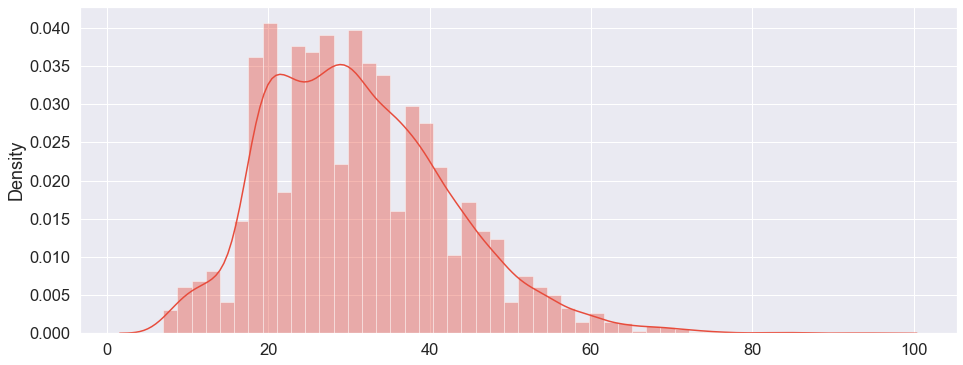

In [33]:
fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

In [34]:
train= combined[:idx]
test = combined[idx:]
train.shape

(7530,)

In [35]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [36]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [37]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,024 training samples
1,506 validation samples


In [38]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [39]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [40]:
from transformers import RobertaModel, AutoModelForSequenceClassification

In [41]:
model = RobertaModel.from_pretrained("allegro/herbert-klej-cased-v1")

In [42]:
model = AutoModelForSequenceClassification.from_pretrained(model_names["herbert-klej-cased-v1"]["model"],
                                  num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
                                  output_attentions = False, # Whether the model returns attentions weights.
                                  output_hidden_states = False, # Whether the model returns all hidden-states.
                                  )
model.to(device)

Some weights of the model checkpoint at allegro/herbert-klej-cased-v1 were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-klej-cased-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50560, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [43]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50560, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [44]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

# The 'W' stands for 'Weight Decay fix' probably...

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [45]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 

# We chose to run for 3, but we'll see later that this may be over-fitting the training data.

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training and Evaluating
Time to train our model! First we set some helper functions to calculate our metrics and time spent on the process. Then it moves like this, directly from the original notebook, it's pretty good at explaining I shouldn't confuse you with my own way of telling I guess:
Training:

Unpack our data inputs and labels
Load data onto the GPU for acceleration,
Clear out the gradients calculated in the previous pass,
In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out,
Forward pass (feed input data through the network),
Backward pass (backpropagation),
Tell the network to update parameters with optimizer.step(),
Track variables for monitoring progress.
Evalution:

Unpack our data inputs and labels,
Load data onto the GPU for acceleration,
Forward pass (feed input data through the network),
Compute loss on our validation data and track variables for monitoring progress.
Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line.

The code below trains according to our data and saves the learning progress on the way so we can summarize at the end and see our results. We can also turn these to dataframe and plot it to see our eavluation better. So we can decide if the model performs well and not overfitting...

In [46]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [47]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [48]:
# This training code is based on the `run_glue.py` script here:

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

# For each epoch...

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:
    
    t0 = time.time()

    # Reset the total loss for this epoch.
    
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
    
    # `dropout` and `batchnorm` layers behave differently during training vs. test ,
    # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    
    model.train()

    # For each batch of training data...
    
    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
        # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is down here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
        
        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                            return_dict=False )

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        
        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
        
        optimizer.step()

        # Update the learning rate.
        
        scheduler.step()

    # Calculate the average loss over all of the batches.
    
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    
    model.eval()

    # Tracking variables:
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).
        
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        
        total_eval_loss += loss.item()

        # Move logits and labels to CPU:
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
        
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    
    # Report the final f1 score for this validation run.
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    
    
    # Measure how long the validation run took:
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.
    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.00 GiB total capacity; 2.42 GiB already allocated; 0 bytes free; 2.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Display floats with two decimal places.

pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

In [ ]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

2241